In [2]:
%cd ~/bench

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [3]:
%load_ext autoreload
%autoreload 2
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.colors as mcolors
import src.utils.plotting as plotting
from src.utils.logging import read_logs
from matplotlib.gridspec import GridSpec

import tarfile
import json
import pandas as pd 
cfg = pl.Config()
cfg.set_fmt_str_lengths(150)

polars.config.Config

# Combine all results 

In [4]:
root_path = Path("results/big_batch")
df_list = []
for rpath in root_path.iterdir():
    df_raw = read_logs(exp_name=None, exp_path=rpath)
    df_list.append(df_raw)

df_results = pl.concat(df_list)

# BIG BATCH

In [5]:
df_ = df_results.select(
    pl.col(
        [
            "scenario_id",
            "target_dl",
            "jd_method",
            "base_table",
            "estimator",
            "chosen_model",
            "aggregation",
            "r2score",
            "time_fit",
            "time_predict",
            "time_run",
            "epsilon",
        ]
    )
).filter(
    (~pl.col("base_table").str.contains("open_data"))
    & (pl.col("target_dl") != "wordnet_big")
)

In [6]:
df_ = df_.group_by(
    ["target_dl", "jd_method", "base_table", "estimator", "chosen_model"]
).map_groups(lambda x: x.with_row_count("fold_id"))

In [7]:
joined = df_.join(
    df_.filter(pl.col("estimator") == "nojoin"),
    on=["target_dl", "jd_method", "base_table", "chosen_model", "fold_id"],
    how="left",
).with_columns((pl.col("r2score") - pl.col("r2score_right")).alias("difference"))

In [8]:
results_full = joined.filter(~pl.col("base_table").str.contains("depleted"))
results_depleted = joined.filter(pl.col("base_table").str.contains("depleted"))

In [9]:
max_diff_full = results_full.select(pl.col("difference").abs().max()).item()
max_diff_full = results_full.with_columns(
    (pl.col("difference") / max_diff_full).alias("scaled_diff")
)
max_diff_depleted = results_depleted.select(pl.col("difference").abs().max()).item()
results_depleted = results_depleted.with_columns(
    (pl.col("difference") / max_diff_depleted).alias("scaled_diff")
)

results_full = results_full.with_columns(
    (pl.col("difference") / max_diff_depleted).alias("scaled_diff")
)

results_depleted = results_depleted.with_columns(
    (pl.col("difference") / max_diff_depleted).alias("scaled_diff")
)

In [10]:
current_results = results_depleted.clone()

# Post-hoc

In [11]:
current_results = current_results.with_columns(
    (pl.col("difference") / max_diff_depleted).alias("scaled_diff")
)

In [12]:
current_results.head()

fold_id,scenario_id,target_dl,jd_method,base_table,estimator,chosen_model,aggregation,r2score,time_fit,time_predict,time_run,epsilon,scenario_id_right,estimator_right,aggregation_right,r2score_right,time_fit_right,time_predict_right,time_run_right,epsilon_right,difference,scaled_diff
u32,i64,str,str,str,str,str,str,f64,f64,f64,f64,f64,i64,str,str,f64,f64,f64,f64,f64,f64,f64
0,79,"""binary_update""","""minhash""","""housing-prices-yadl-depleted""","""best_single_join""","""catboost""","""first""",0.304524,16.087928,0.376039,16.464824,null,79,"""nojoin""","""first""",-0.000192,0.599629,0.009321,0.609729,null,0.304716,0.505126
1,79,"""binary_update""","""minhash""","""housing-prices-yadl-depleted""","""best_single_join""","""catboost""","""first""",0.290669,17.004795,0.450631,17.456726,null,79,"""nojoin""","""first""",-0.000172,0.19054,0.008556,0.199852,null,0.290842,0.482127
2,79,"""binary_update""","""minhash""","""housing-prices-yadl-depleted""","""best_single_join""","""catboost""","""first""",0.301209,16.950179,0.46917,17.420345,null,79,"""nojoin""","""first""",-0.000131,0.542593,0.010932,0.554324,null,0.301341,0.499531
3,79,"""binary_update""","""minhash""","""housing-prices-yadl-depleted""","""best_single_join""","""catboost""","""first""",0.303796,15.802756,0.4048,16.209521,null,79,"""nojoin""","""first""",-0.000131,0.578784,0.011165,0.591843,null,0.303927,0.503817
4,79,"""binary_update""","""minhash""","""housing-prices-yadl-depleted""","""best_single_join""","""catboost""","""first""",0.321411,15.187321,0.523769,15.712048,null,79,"""nojoin""","""first""",-0.001411,0.119879,0.010132,0.130916,null,0.322823,0.535141


In [13]:
# Top 5 scores overall
current_results.group_by(["target_dl", "jd_method", "estimator", "chosen_model"]).agg(
    pl.mean("scaled_diff").alias("avg_scaled_diff"),
    pl.std("scaled_diff").alias("std_scaled_diff"),
).top_k(k=5, by="avg_scaled_diff")

target_dl,jd_method,estimator,chosen_model,avg_scaled_diff,std_scaled_diff
str,str,str,str,f64,f64
"""binary_update""","""exact_matching""","""stepwise_greedy_join""","""catboost""",0.513866,0.302553
"""binary_update""","""exact_matching""","""full_join""","""catboost""",0.511494,0.302724
"""wordnet_full_flat""","""exact_matching""","""stepwise_greedy_join""","""catboost""",0.486717,0.346504
"""wordnet_full_flat""","""exact_matching""","""full_join""","""catboost""",0.48388,0.350774
"""wordnet_full_flat""","""exact_matching""","""best_single_join""","""catboost""",0.461891,0.367982


For each variable, I am going to find the best configuration on averge, then fix that value for comparison in other plots. 

In [14]:
best_value = {}
for v in ["target_dl", "jd_method", "estimator", "chosen_model"]:
    this_best = (
        current_results.group_by(v)
        .agg(
            pl.mean("scaled_diff").alias("avg_scaled_diff"),
        )
        .top_k(k=5, by="avg_scaled_diff")
    )
    best_value[v] = this_best.top_k(1, by="avg_scaled_diff")[v].item()
    display(this_best)

target_dl,avg_scaled_diff
str,f64
"""wordnet_full_flat""",0.241706
"""binary_update""",0.204701


jd_method,avg_scaled_diff
str,f64
"""exact_matching""",0.276931
"""minhash""",0.169476


estimator,avg_scaled_diff
str,f64
"""full_join""",0.339585
"""stepwise_greedy_join""",0.336955
"""best_single_join""",0.253873
"""highest_containment""",0.185604
"""nojoin""",0.0


chosen_model,avg_scaled_diff
str,f64
"""catboost""",0.262856
"""linear""",0.18355


In [15]:
best_value

{'target_dl': 'wordnet_full_flat',
 'jd_method': 'exact_matching',
 'estimator': 'full_join',
 'chosen_model': 'catboost'}

### Variable: Target DL

In [16]:
def prepare_data(df, target_variable):
    values = (
        df.filter(pl.col("estimator") != "nojoin")
        .with_columns(
            pl.col("estimator").cast(pl.Categorical).to_physical().alias("est_cat")
        )
        .group_by(target_variable)
        .agg(pl.all())
        .select(
            pl.col(target_variable),
            pl.col("scaled_diff"),
            pl.col("estimator"),
            pl.col("est_cat"),
        )
    )
    values_dict = values.to_dict()
    data = [np.array(arr) for arr in values_dict["scaled_diff"]]
    label_mapping = (
        df.filter(pl.col("estimator") != "nojoin")
        .select(
            pl.col("estimator").cast(pl.Categorical).cat.get_categories().alias("label")
        )
        .with_row_count("idx")
        .to_dict()
    )
    return data, values_dict, label_mapping

In [17]:
target_variable = "jd_method"
data, values_dict, label_mapping = prepare_data(current_results, target_variable)

In [18]:
cases = (
    current_results.filter(pl.col("estimator") != "nojoin")
    .select(pl.col(["jd_method", "chosen_model", "estimator"]).unique().implode())
    .transpose(include_header=True)
    .to_dict(as_series=False)
)

cases = dict(zip(*list(cases.values())))

In [19]:
import itertools

sum(1 for _ in itertools.product(*cases.values()))

16

In [20]:
for outer_variable in cases:
    plotting.draw_plot(cases, outer_variable, current_results)

TypeError: draw_plot() missing 1 required positional argument: 'inner_dimensions'

exact_matching
minhash
catboost
linear


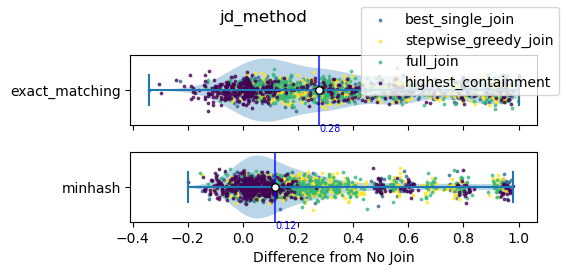

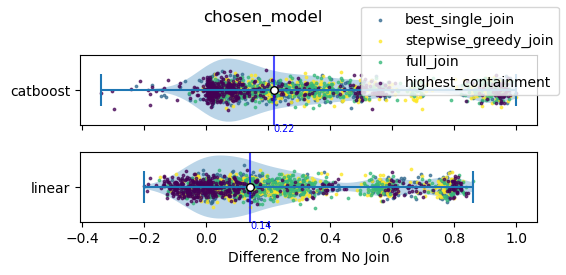

In [ ]:
target_variable = "jd_method"
for tg in ["jd_method", "chosen_model"]:
    data, values_dict, label_mapping = prepare_data(results_depleted, tg)
    plotting.violin_plot(data, values_dict, label_mapping, tg)
    # break

In [ ]:
from itertools import combinations

In [ ]:
best_value

{'target_dl': 'wordnet_full_flat',
 'jd_method': 'exact_matching',
 'estimator': 'full_join',
 'chosen_model': 'catboost'}

In [ ]:
list(combinations(best_value.items(), 3))

[(('target_dl', 'wordnet_full_flat'),
  ('jd_method', 'exact_matching'),
  ('estimator', 'full_join')),
 (('target_dl', 'wordnet_full_flat'),
  ('jd_method', 'exact_matching'),
  ('chosen_model', 'catboost')),
 (('target_dl', 'wordnet_full_flat'),
  ('estimator', 'full_join'),
  ('chosen_model', 'catboost')),
 (('jd_method', 'exact_matching'),
  ('estimator', 'full_join'),
  ('chosen_model', 'catboost'))]

In [ ]:
for comb in combinations(best_value.items(), 2):
    case1, case2 = comb
    t_f = current_results.filter(
        (pl.col(case1[0]) == case1[1]) & (pl.col(case1[0]) == case1[1])
    )

In [ ]:
for tg in ["jd_method", "chosen_model", "estimator"]:
    filter_values = [(k, v) for k, v in best_value.items() if k != tg]
    c1, c2, c3 = filter_values
    t_f = current_results.filter(
        (pl.col(c1[0]) == c1[1]) & (pl.col(c2[0]) == c2[1]) & (pl.col(c3[0]) == c3[1])
    )

    # fig, ax = plt.subplots(1)
    # sns.violinplot(data=t_f.to_pandas(), x="scaled_diff", y=tg, ax=ax)

# Effect of pipeline steps 

In [ ]:
best_value = {}
worst_value = {}
for v in ["jd_method", "estimator", "chosen_model"]:
    this_best = (
        current_results.filter(pl.col("estimator") != "nojoin")
        .group_by(v)
        .agg(
            pl.mean("scaled_diff").alias("avg_scaled_diff"),
        )
        .top_k(k=5, by="avg_scaled_diff")
    )
    best_value[v] = this_best.top_k(1, by="avg_scaled_diff")[v].item()
    worst_value[v] = this_best.bottom_k(1, by="avg_scaled_diff")[v].item()
    display(this_best)

jd_method,avg_scaled_diff
str,f64
"""exact_matching""",0.346163
"""minhash""",0.211845


estimator,avg_scaled_diff
str,f64
"""full_join""",0.339585
"""stepwise_greedy_join""",0.336955
"""best_single_join""",0.253873
"""highest_containment""",0.185604


chosen_model,avg_scaled_diff
str,f64
"""catboost""",0.328571
"""linear""",0.229438


In [ ]:
# Top 5 scores overall
comb_results = (
    current_results.group_by(["jd_method", "estimator", "chosen_model"])
    .agg(
        pl.mean("scaled_diff").alias("avg_scaled_diff"),
        pl.std("scaled_diff").alias("std_scaled_diff"),
    )
    .sort("avg_scaled_diff", descending=True)
    .filter(pl.col("estimator") != "nojoin")
)

In [ ]:
worst_value

{'jd_method': 'minhash',
 'estimator': 'highest_containment',
 'chosen_model': 'linear'}

In [ ]:
comb_results.filter(**worst_value)["avg_scaled_diff"].item()

0.12732336174138634

In [ ]:
current_value = dict(worst_value)
all_values = [current_value]
for k, v in best_value.items():
    new_value = dict(current_value)
    new_value.update({k: v})
    all_values.append(new_value)
    current_value = new_value

In [ ]:
vals_to_plot = []
for data in all_values:
    vals_to_plot.append(comb_results.filter(**data))

In [ ]:
pl.concat(vals_to_plot).select(pl.col("avg_scaled_diff").diff())

avg_scaled_diff
f64
null
0.028273
0.192589
0.149501


In [ ]:
df_waterfall = (
    pl.concat(vals_to_plot)
    .with_columns(
        (
            pl.col("jd_method")
            + "\n"
            + pl.col("estimator")
            + "\n"
            + pl.col("chosen_model")
        ).alias("case")
    )
    .select(pl.col("case"), pl.col("avg_scaled_diff").alias("value"))
)

In [ ]:
_t = df_waterfall.with_columns(
    pl.col("value").alias("bottom").shift(1).fill_null(0),
    pl.col("value").diff().alias("diff").fill_null(pl.col("value")),
).to_pandas()

In [ ]:
_t = (
    df_waterfall.with_columns(
        pl.col("value").alias("bottom").shift(1).fill_null(0),
        pl.col("value").diff().alias("diff").fill_null(pl.col("value")),
    )
    .with_columns(
        pl.col("diff").cumsum().alias("fill"),
    )
    .to_pandas()
)

In [ ]:
_t

,case,value,bottom,diff,fill
0,minhash\nhighest_containment\nlinear,0.127323,0.000000,0.127323,0.127323
1,exact_matching\nhighest_containment\nlinear,0.155597,0.127323,0.028273,0.155597
2,exact_matching\nfull_join\nlinear,0.348186,0.155597,0.192589,0.348186
3,exact_matching\nfull_join\ncatboost,0.497687,0.348186,0.149501,0.497687


Text(0.5, 0, 'Difference wtr nojoin')

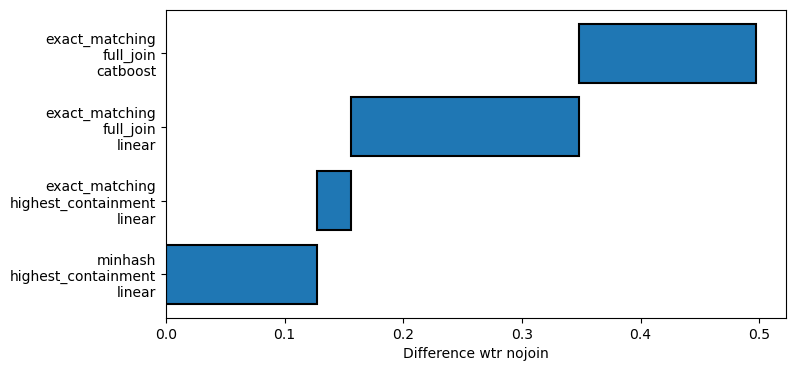

In [ ]:
# plt.bar(bottom="bottom",height="diff", x="case", data=_t)
fig, ax = plt.subplots(1, figsize=(8, 4))

# p = ax.barh(
#     width="value", y="case", data=_t, edgecolor="black", linewidth=1.5, color="green"
# )
# ax.bar_label(p, [f"{_:.2f}" for _ in _t["value"]])
# ax.barh(
#     width="bottom", y="case", data=_t, edgecolor="black", linewidth=1.5, color="red"
# )


# MINE
ax.barh(
    left="bottom", width="diff", y="case", data=_t, edgecolor="black", linewidth=1.5
)


# step = (
#     pl.from_pandas(_t)
#     .select(pl.col("bottom").repeat_by(3).list.explode())
#     .shift(-1)
#     .to_numpy()
# )
# step[1::3] = np.nan
# mask = np.repeat(
#     np.arange(5),
#     3,
# )
# plt.plot(step, mask, color="black", zorder=2, linewidth=1)
ax.set_xlabel("Difference wtr nojoin")

In [ ]:
current_results.head()

fold_id,scenario_id,target_dl,jd_method,base_table,estimator,chosen_model,aggregation,r2score,time_fit,time_predict,time_run,epsilon,case,scenario_id_right,estimator_right,aggregation_right,r2score_right,time_fit_right,time_predict_right,time_run_right,epsilon_right,case_right,difference,scaled_diff
u32,i64,str,str,str,str,str,str,f64,f64,f64,f64,f64,str,i64,str,str,f64,f64,f64,f64,f64,str,f64,f64
0,79,"""binary_update""","""minhash""","""housing-prices-yadl-depleted""","""best_single_join""","""catboost""","""first""",0.304524,16.087928,0.376039,16.464824,null,"""minhash | binary_update""",79,"""nojoin""","""first""",-0.000192,0.599629,0.009321,0.609729,null,"""minhash | binary_update""",0.304716,0.505126
1,79,"""binary_update""","""minhash""","""housing-prices-yadl-depleted""","""best_single_join""","""catboost""","""first""",0.290669,17.004795,0.450631,17.456726,null,"""minhash | binary_update""",79,"""nojoin""","""first""",-0.000172,0.19054,0.008556,0.199852,null,"""minhash | binary_update""",0.290842,0.482127
2,79,"""binary_update""","""minhash""","""housing-prices-yadl-depleted""","""best_single_join""","""catboost""","""first""",0.301209,16.950179,0.46917,17.420345,null,"""minhash | binary_update""",79,"""nojoin""","""first""",-0.000131,0.542593,0.010932,0.554324,null,"""minhash | binary_update""",0.301341,0.499531
3,79,"""binary_update""","""minhash""","""housing-prices-yadl-depleted""","""best_single_join""","""catboost""","""first""",0.303796,15.802756,0.4048,16.209521,null,"""minhash | binary_update""",79,"""nojoin""","""first""",-0.000131,0.578784,0.011165,0.591843,null,"""minhash | binary_update""",0.303927,0.503817
4,79,"""binary_update""","""minhash""","""housing-prices-yadl-depleted""","""best_single_join""","""catboost""","""first""",0.321411,15.187321,0.523769,15.712048,null,"""minhash | binary_update""",79,"""nojoin""","""first""",-0.001411,0.119879,0.010132,0.130916,null,"""minhash | binary_update""",0.322823,0.535141


In [ ]:
cases

{'jd_method': ['exact_matching', 'minhash'],
 'chosen_model': ['catboost', 'linear'],
 'estimator': ['stepwise_greedy_join',
  'best_single_join',
  'full_join',
  'highest_containment']}

In [ ]:
# Variable used to group boxplots
target_variable = "estimator"
# Variable used to paint scatterplots
scatter_variable = "chosen_model"
# Variable used to group plots by
outer_variable = "jd_method"

colormap_name = "viridis"

fig, axs = plt.subplots(1, len(cases[outer_variable]), sharey=True, sharex=True)
for i_outer, value in enumerate(cases[outer_variable]):
    ax = axs[i_outer]
    ax.set_title(value)

    projection = [
        "fold_id",
        "target_dl",
        "jd_method",
        "estimator",
        "chosen_model",
        "r2score",
        "scaled_diff",
    ]

    all_groupby_variables = [
        "fold_id",
        "target_dl",
        "jd_method",
        "estimator",
        "chosen_model",
    ]

    this_groupby = [_ for _ in all_groupby_variables if _ != target_variable]

    _prep = (
        current_results.filter(pl.col("estimator") != "nojoin")
        .filter(pl.col(outer_variable) == value)
        .select(projection)
        .join(
            current_results.select(projection)
            .group_by(this_groupby)
            .agg(pl.mean("scaled_diff").alias("avg_scaled_diff")),
            on=this_groupby,
        )
        .with_columns(
            (pl.col("scaled_diff") - pl.col("avg_scaled_diff")).alias("diff_from_mean")
        )
    )
    _prep_dict = (
        _prep.select(target_variable, "diff_from_mean")
        .group_by(target_variable, maintain_order=True)
        .agg(pl.all(), pl.mean("diff_from_mean").alias("avg_diff"))
        .sort("avg_diff")
        .drop("avg_diff")
        .to_dict()
        # .to_pandas()
    )
    _data = dict(zip(*list(_prep_dict.values())))
    ax.violinplot(dataset=_data.values(), vert=False)
    # ax.boxplot(
    #     x=_data.values(), showfliers=True, vert=False
    # )

    colors = plt.colormaps[colormap_name](
        np.linspace(0, 1, _prep.select(pl.col(scatter_variable).n_unique()).item())
    )
    for inum, (gidx, group) in enumerate(_prep.group_by(scatter_variable)):
        _scatter_dict = (
            _prep.select(target_variable, "diff_from_mean")
            .group_by(target_variable, maintain_order=True)
            .agg(pl.all(), pl.mean("diff_from_mean").alias("avg_diff"))
            .sort("avg_diff")
            .drop("avg_diff")
            .to_dict()
            # .to_pandas()
        )
        _data = dict(zip(*list(_scatter_dict.values())))
        ax.scatter(
            x=list(_data.values()),
            y=[
                _ + plotting.add_jitter(np.ones_like(v), 0.1) for _ in range(len(_data))
            ],
            label=gidx,
            color=colors[inum],
            alpha=0.7,
            s=3,
        )

        # for i, v in enumerate(_data.values()):
        #     ax.scatter(
        #         x=v,
        #         y=add_jitter(i + np.ones_like(v), 0.1),
        #         label=gidx,
        #         color=colors[inum],
        #         alpha=0.7,
        #         s=3,
        #     )
    ax.set_yticks(range(1, len(data) + 1), list(data.keys()))
h, l = ax.get_legend_handles_labels()
fig.legend(h, l)

NameError: name 'plt' is not defined